Save model epoch =    2, loss = 51.0681
Save model epoch =    3, loss = 12.6505
Save model epoch =    4, loss = 5.6752
Save model epoch =    5, loss = 4.0360
Save model epoch =    6, loss = 3.3920
Save model epoch =    7, loss = 2.8617
Save model epoch =    8, loss = 2.4789
Save model epoch =    9, loss = 2.2375
Save model epoch =   10, loss = 2.0216
Save model epoch =   11, loss = 1.8489
Save model epoch =   12, loss = 1.7353
Save model epoch =   13, loss = 1.5770
Save model epoch =   14, loss = 1.5064
Save model epoch =   15, loss = 1.4060
Save model epoch =   16, loss = 1.3681
Save model epoch =   17, loss = 1.3126
Save model epoch =   18, loss = 1.2665
Save model epoch =   19, loss = 1.2314
Save model epoch =   20, loss = 1.1806
Save model epoch =   22, loss = 1.1721
Save model epoch =   26, loss = 1.1052
Save model epoch =   27, loss = 1.0713
Save model epoch =   30, loss = 1.0334
Save model epoch =   31, loss = 1.0146
Save model epoch =   34, loss = 1.0106
Save model epoch =   37

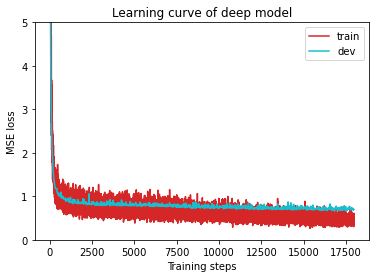

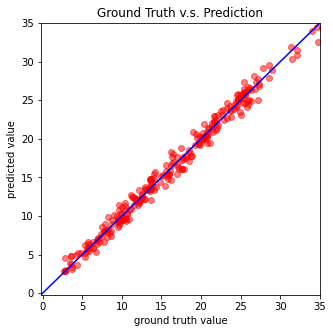

Saving results to mypred.csv
all done


In [1]:
import numpy as np
import csv
import torch
import os
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

seed = 42069
np.random.seed(seed)
torch.manual_seed(seed)

class Covid19Sets(Dataset):
    def __init__(self, path, model = 'train'):
        super().__init__()
        self.model = model
        with open(path) as file :
            data_csv = list(csv.reader(file))
            data = np.array(data_csv[1 : ])[ : , 1 :].astype(float)
        if model == 'test' :
            data = data[ : , 0 : 93]
            self.data = torch.FloatTensor(data)
        else :
            target = data[ : , -1]
            data = data[:, 0 : 93]
            train_index = []
            dev_index = []
            for i in range(data.shape[0]) :
                if i % 10 == 0 :
                    dev_index.append(i)
                else :
                    train_index.append(i)
            if model == 'train' :
                self.target = torch.FloatTensor(target[train_index])
                self.data = torch.FloatTensor(data[train_index,  0 : 93])
            else :
                self.target = torch.FloatTensor(target[dev_index])
                self.data = torch.FloatTensor(data[dev_index, 0 : 93])
        self.data[: , 40 : ] = (self.data[:, 40 :] - self.data[:, 40 : ].mean(dim = 0)) / self.data[: , 40 :].std(dim = 0)
        self.dim = self.data.shape[1]
    
    def __getitem__(self, item):
        if self.model == 'train' or self.model == 'dev' :
            return self.data[item], self.target[item]
        else :
            return self.data[item]
    def __len__(self):
        return len(self.data)
def prep_dataloader(path, model, batch_size, num_works = 0) :
    dataset = Covid19Sets(path, model)
    dataLoaderset = DataLoader(dataset,
                               batch_size,
                               shuffle=(model == 'train'),
                               drop_last=False,
                               num_workers=num_works,
                               pin_memory=False)
    #print(model)
    return dataLoaderset

def prep_dataloader(path, model, batch_size, num_works = 0) :
    dataset = Covid19Sets(path, model)
    dataLoaderset = DataLoader(dataset,
                               batch_size,
                               shuffle=(model == 'train'),
                               drop_last=False,
                               num_workers=num_works,
                               pin_memory=False)
    #print(model)
    return dataLoaderset

class Mymodel(nn.Module) :
    def __init__(self, input_dim):
        super(Mymodel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        self.critertion = nn.MSELoss(reduction='mean')
    def forward(self, input):
        return self.net(input).squeeze(1)
    def cal_loss(self, pred, target):
        return self.critertion(pred, target)

def train(model, train_data, dev_data) :
    max_epoch = 1000
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
    train_loss = []
    dev_loss = []
    min_mse = 1000
    break_flag = 0
    while epoch < max_epoch :
        model.train()
        for input, label in train_data :
            optimizer.zero_grad()
            output = model(input)
            loss = model.cal_loss(output, label)
            train_loss.append(loss.detach())
            loss.backward()
            optimizer.step()
        dev_mse = dev(model, dev_data)
        if dev_mse < min_mse :
            min_mse = dev_mse
            print('Save model epoch = {:4d}, loss = {:.4f}'.format(epoch + 1, min_mse))
            torch.save(model.state_dict(), 'my_models/mymodel.pth')
            break_flag = 0
        else :
            break_flag += 1
        dev_loss.append(dev_mse.detach())
        if break_flag > 200 :
            break
        epoch += 1
    return train_loss, dev_loss
def dev(model, dev_data) :
    model.eval()
    total_loss = []
    for input, label in dev_data :
        output = model(input)
        total_loss.append(model.cal_loss(output, label))
    return sum(total_loss) / len(total_loss)

def test(model,test_data) :
    model.eval()
    output = []
    for input in test_data :
        pred = model(input)
        output.append(pred.detach())
    output = torch.cat(output, dim = 0).numpy()
    return output


# 绘制学习曲线
def plot_learning_curve(train_loss, dev_loss, title=''):
    total_steps = len(train_loss)
    x_1 = range(total_steps)
    x_2 = x_1[::len(train_loss) // len(dev_loss)]
    plt.figure(1, figsize=(6, 4))
    plt.plot(x_1, train_loss, c='tab:red', label='train')
    plt.plot(x_2, dev_loss, c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    plt.figure(2, figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()


def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):  # enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列，同时列出数据和数据下标
            writer.writerow([i, p])


os.makedirs('my_models', exist_ok=True)

# 加载数据
train_data = prep_dataloader('covid.train.csv', 'train', batch_size=135)
dev_data = prep_dataloader('covid.train.csv', 'dev', batch_size=135)
test_data = prep_dataloader('covid.test.csv', 'test', batch_size=135)

mymodel = Mymodel(train_data.dataset.dim)
train_loss, dev_loss = train(mymodel, train_data, dev_data)
plot_learning_curve(train_loss, dev_loss, title='deep model')
del mymodel

model = Mymodel(train_data.dataset.dim)
ckpt = torch.load('my_models/mymodel.pth', map_location='cpu')  # 加载最好的模型
model.load_state_dict(ckpt)
plot_pred(dev_data, model, 'cpu')
preds = test(model, test_data)

save_pred(preds, 'mypred.csv')
print('all done')
